# Zero-Shot CLIP Inference with OpenVINO

This notebook performs image and text-based search using zero-shot CLIP model optimized with OpenVINO.

In [94]:
import os
import numpy as np
import pickle
from pathlib import Path
from PIL import Image
import torch
import clip
from openvino.runtime import Core
import faiss
import matplotlib.pyplot as plt

## Configuration

In [95]:
MODEL_DIR = Path(r"e:\Projects\AI Based\RecTrio\V1\models")
VECTOR_DB_DIR = Path(r"e:\Projects\AI Based\RecTrio\V1\vector_db")

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
VECTOR_DB_DIR.mkdir(parents=True, exist_ok=True)

CLIP_MODEL_NAME = "ViT-B/32"  # Fast GitHub CLIP model
VISION_MODEL_PATH = MODEL_DIR / "clip_vision_model.xml"
TEXT_MODEL_PATH = MODEL_DIR / "clip_text_model.xml"
FAISS_INDEX_PATH = VECTOR_DB_DIR / "faiss_index.bin"
METADATA_PATH = VECTOR_DB_DIR / "metadata.pkl"

TOP_K = 10

print(f"✓ Model directory: {MODEL_DIR}")
print(f"✓ Vector DB directory: {VECTOR_DB_DIR}")

✓ Model directory: e:\Projects\AI Based\RecTrio\V1\models
✓ Vector DB directory: e:\Projects\AI Based\RecTrio\V1\vector_db


## Load Processor and Model Components

In [96]:
print("Loading CLIP model (fast GitHub version)...")
model, preprocess = clip.load(CLIP_MODEL_NAME, device="cpu")
model.eval()
print(f"✓ CLIP {CLIP_MODEL_NAME} loaded successfully (in ~2-3 seconds!)")

Loading CLIP model (fast GitHub version)...
✓ CLIP ViT-B/32 loaded successfully (in ~2-3 seconds!)
✓ CLIP ViT-B/32 loaded successfully (in ~2-3 seconds!)


## Load OpenVINO Models

In [97]:
core = Core()

print("Loading vision model...")
vision_compiled_model = core.compile_model(str(VISION_MODEL_PATH), "CPU")
vision_input_layer = vision_compiled_model.input(0)
vision_output_layer = vision_compiled_model.output(0)

print("Loading text model...")
text_compiled_model = core.compile_model(str(TEXT_MODEL_PATH), "CPU")
text_output_layer = text_compiled_model.output(0)

print("OpenVINO models loaded on CPU")

Loading vision model...
Loading text model...
Loading text model...
OpenVINO models loaded on CPU
OpenVINO models loaded on CPU


## Load FAISS Index and Metadata

In [98]:
print("Loading FAISS index...")
index = faiss.read_index(str(FAISS_INDEX_PATH))
print(f"Loaded index with {index.ntotal} vectors")

print("Loading metadata...")
with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

image_paths = metadata['image_paths']
print(f"Loaded {len(image_paths)} image paths")

Loading FAISS index...
Loaded index with 26179 vectors
Loading metadata...
Loaded 26179 image paths


## Embedding Functions

In [99]:
def get_image_embedding(image_input):
    """Generate image embedding using OpenVINO vision model"""
    if isinstance(image_input, str):
        image = Image.open(image_input).convert('RGB')
    else:
        image = image_input.convert('RGB')
    
    image_tensor = preprocess(image).unsqueeze(0)
    pixel_values = image_tensor.numpy()
    
    # Run inference with OpenVINO
    result = vision_compiled_model([pixel_values])[vision_output_layer]
    
    # Get embedding and normalize
    embedding = result[0]
    embedding = embedding / np.linalg.norm(embedding)
    
    return embedding.astype('float32')

def get_text_embedding(text):
    """Generate text embedding using OpenVINO text model"""
    # Use CLIP's tokenization
    text_tokens = clip.tokenize([text])
    
    # Run inference with OpenVINO
    result = text_compiled_model([text_tokens.numpy()])[text_output_layer]
    
    # Get embedding and normalize
    embedding = result[0]
    embedding = embedding / np.linalg.norm(embedding)
    
    return embedding.astype('float32')

## Search Function

In [100]:
def search_similar_images(query_embedding, top_k=TOP_K):
    query_embedding = query_embedding.reshape(1, -1)
    
    distances, indices = index.search(query_embedding, top_k)
    
    results = []
    for idx, dist in zip(indices[0], distances[0]):
        results.append({
            'path': image_paths[idx],
            'similarity': float(dist)
        })
    
    return results

## Visualization Function

In [101]:
def display_results(results, query_info=None):
    # Filter out missing images
    valid_results = []
    for result in results:
        if os.path.exists(result['path']):
            valid_results.append(result)
        else:
            # Try alternative path (remove V1 from path if present)
            alt_path = result['path'].replace(r"\V1\datasets", r"\datasets")
            if os.path.exists(alt_path):
                result['path'] = alt_path
                valid_results.append(result)
            else:
                print(f"⚠ Skipping missing image: {result['path']}")
    
    if not valid_results:
        print("No valid images found in results!")
        return
    
    n_results = len(valid_results)
    cols = 5
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if n_results > 1 else [axes]
    
    for idx, result in enumerate(valid_results):
        img = Image.open(result['path'])
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Similarity: {result['similarity']:.4f}", fontsize=10)
    
    for idx in range(n_results, len(axes)):
        axes[idx].axis('off')
    
    if query_info:
        fig.suptitle(f"Query: {query_info}", fontsize=14, y=1.00)
    
    plt.tight_layout()
    plt.show()

## Image-Based Search

Searching for images similar to: e:\Projects\AI Based\RecTrio\datasets\animals\raw-img\cat\1.jpeg

Top 10 similar images:
1. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1.jpeg (Similarity: 1.0000)
2. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\41.jpeg (Similarity: 0.9357)
3. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\51.jpeg (Similarity: 0.9271)
4. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\944.jpeg (Similarity: 0.9261)
5. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\547.jpeg (Similarity: 0.9255)
6. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\477.jpeg (Similarity: 0.9228)
7. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\44.jpeg (Similarity: 0.9169)
8. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1002.jpeg (Similarity: 0.9164)
9. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\442.jpeg (Similarity: 0.9163)
10. e:\Projects\AI Based\RecTrio\V1\

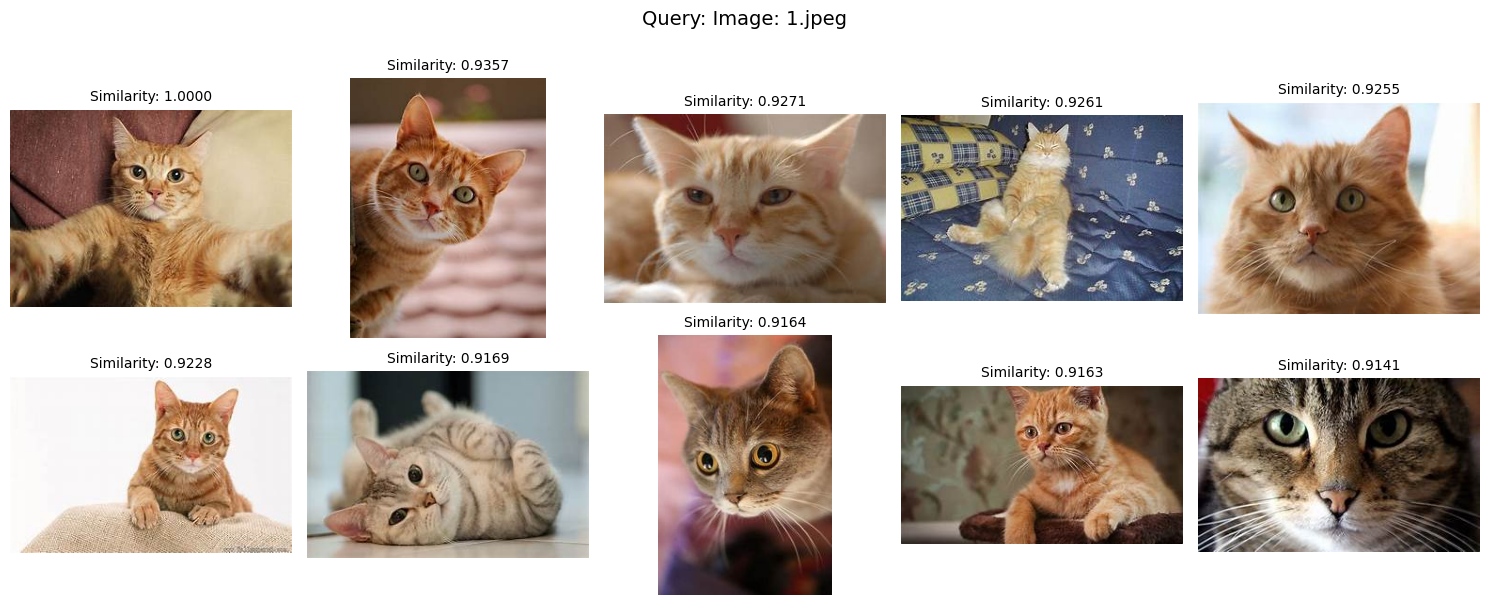

In [102]:
query_image_path = r"e:\Projects\AI Based\RecTrio\datasets\animals\raw-img\cat\1.jpeg"

print(f"Searching for images similar to: {query_image_path}")
query_embedding = get_image_embedding(query_image_path)
results = search_similar_images(query_embedding)

print(f"\nTop {len(results)} similar images:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")

display_results(results, query_info=f"Image: {Path(query_image_path).name}")

## Text-Based Search

Searching for: 'a photo of a cat'

Top 10 similar images:
1. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1543.jpeg (Similarity: 0.3088)
2. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ee32b90c29f11c22d2524518b7444f92e37fe5d404b0144390f8c079a4e5b6_640.jpg (Similarity: 0.3077)
3. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ea37b1092cf4053ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg (Similarity: 0.3074)
4. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\702.jpeg (Similarity: 0.3062)
5. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ea36b20c2ff2003ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg (Similarity: 0.3058)
6. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\1769.jpeg (Similarity: 0.3056)
7. e:\Projects\AI Based\RecTrio\V1\datasets\animals\raw-img\cat\ea37b6072df1023ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg (Similarity: 0.3052)
8. e:\Projects\AI Based\RecT

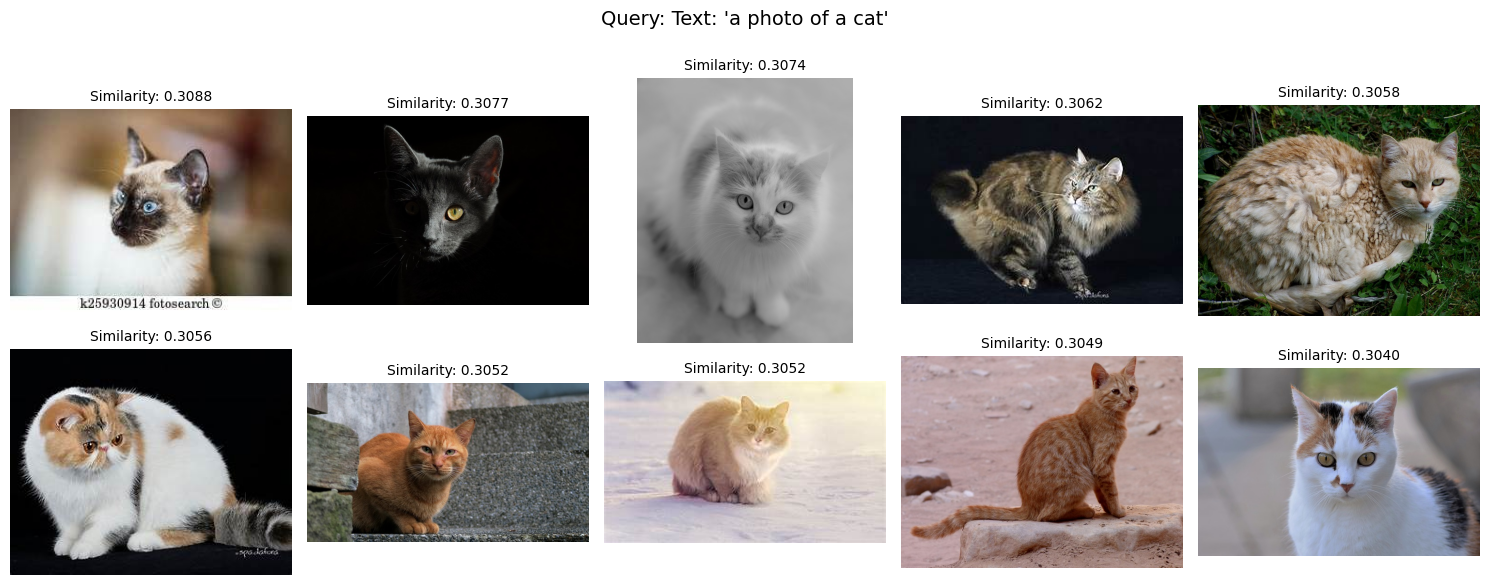

In [103]:
query_text = "a photo of a cat"

print(f"Searching for: '{query_text}'")
query_embedding = get_text_embedding(query_text)
results = search_similar_images(query_embedding)

print(f"\nTop {len(results)} similar images:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")

display_results(results, query_info=f"Text: '{query_text}'")

## Interactive Search

In [104]:
# def interactive_search():
#     print("Choose search type:")
#     print("1. Image search")
#     print("2. Text search")
    
#     choice = input("Enter choice (1-image or 2-text): ").strip()
    
#     if choice == "1":
#         image_path = input("Enter image path: ").strip()
#         if not os.path.exists(image_path):
#             print("Image not found!")
#             return
        
#         print(f"\nSearching for images similar to: {image_path}")
#         query_embedding = get_image_embedding(image_path)
#         results = search_similar_images(query_embedding)
        
#         print(f"\nTop {len(results)} similar images:")
#         for i, result in enumerate(results, 1):
#             print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")
        
#         display_results(results, query_info=f"Image: {Path(image_path).name}")
        
#     elif choice == "2":
#         text_query = input("Enter search text: ").strip()
        
#         print(f"\nSearching for: '{text_query}'")
#         query_embedding = get_text_embedding(text_query)
#         results = search_similar_images(query_embedding)
        
#         print(f"\nTop {len(results)} similar images:")
#         for i, result in enumerate(results, 1):
#             print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")
        
#         display_results(results, query_info=f"Text: '{text_query}'")
#     else:
#         print("Invalid choice!")

# interactive_search()

In [105]:
import json

# Load the knowledge graph
# Use V1 path since the knowledge graph was created in V1/vector_db
KG_PATH = Path(r"e:\Projects\AI Based\RecTrio\V1\vector_db\animal_knowledge_graph.json")

with open(KG_PATH, 'r') as f:
    knowledge_graph = json.load(f)

print("✓ Knowledge graph loaded successfully")
print(f"Entities in knowledge graph: {list(knowledge_graph['entities'].keys())}")

✓ Knowledge graph loaded successfully
Entities in knowledge graph: ['cat', 'dog', 'butterfly', 'chicken', 'cow', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [106]:
def find_entity_from_path(image_path):
    """Extract entity name from image path"""
    path_parts = Path(image_path).parts
    # Find the animal category from the path
    for part in path_parts:
        part_lower = part.lower()
        if part_lower in knowledge_graph['entities']:
            return part_lower
    return None

def get_related_entities(entity_name, max_related=10):
    """
    Get related entities from the knowledge graph with their relationship strengths
    
    Returns:
        List of tuples: [(entity_name, strength), ...]
        Sorted by strength (highest first)
    """
    if entity_name not in knowledge_graph['entities']:
        return []
    
    entity_info = knowledge_graph['entities'][entity_name]
    related = entity_info.get('related_entities', {})
    
    # Convert dict to list of tuples and sort by strength
    related_list = [(entity, strength) for entity, strength in related.items()]
    related_list.sort(key=lambda x: -x[1])  # Sort by strength descending
    
    return related_list[:max_related]

def add_entity_relationship(entity1, entity2, strength=0.5):
    """
    Add a relationship between two entities with a strength metric (bidirectional)
    This allows dynamic updates based on user searches
    
    Args:
        entity1: First entity name
        entity2: Second entity name
        strength: Relationship strength (0.0 to 1.0)
    """
    if entity1 not in knowledge_graph['entities']:
        knowledge_graph['entities'][entity1] = {'related_entities': {}}
    
    if entity2 not in knowledge_graph['entities']:
        knowledge_graph['entities'][entity2] = {'related_entities': {}}
    
    # Add bidirectional relationship with strength
    knowledge_graph['entities'][entity1]['related_entities'][entity2] = strength
    knowledge_graph['entities'][entity2]['related_entities'][entity1] = strength
    
    print(f"✓ Added relationship: {entity1} ↔ {entity2} (strength: {strength:.2f})")

def update_relationship_strength(entity1, entity2, new_strength):
    """
    Update the strength of an existing relationship
    
    Args:
        entity1: First entity name
        entity2: Second entity name
        new_strength: New relationship strength (0.0 to 1.0)
    """
    if entity1 in knowledge_graph['entities'] and entity2 in knowledge_graph['entities']['related_entities']:
        knowledge_graph['entities'][entity1]['related_entities'][entity2] = new_strength
        knowledge_graph['entities'][entity2]['related_entities'][entity1] = new_strength
        print(f"✓ Updated relationship strength: {entity1} ↔ {entity2} → {new_strength:.2f}")
    else:
        print(f"⚠ Relationship not found: {entity1} ↔ {entity2}")

def save_knowledge_graph():
    """Save the updated knowledge graph to disk"""
    import json
    with open(KG_PATH, 'w') as f:
        json.dump(knowledge_graph, f, indent=2)
    print("✓ Knowledge graph saved")

print("✓ Knowledge graph helper functions defined (with relationship strength support)")

✓ Knowledge graph helper functions defined (with relationship strength support)


In [107]:
def kg_based_recommendation(query_input, input_type='image', top_k=10, use_semantic_expansion=False):
    """
    Get recommendations using knowledge graph with relationship strength weighting
    Returns ONLY images from RELATED classes (excludes query class)
    
    Args:
        query_input: Image path or text query
        input_type: 'image' or 'text'
        top_k: Number of recommendations to return
        use_semantic_expansion: Deprecated (kept for compatibility)
    
    Returns:
        Dictionary with entity info and recommendations
    """
    results = {
        'query_entity': None,
        'related_entities': [],
        'recommendations': []
    }
    
    # Step 1: Get initial query embedding and find entity
    if input_type == 'image':
        query_embedding = get_image_embedding(query_input)
        # Extract entity from image path
        query_entity = find_entity_from_path(query_input)
    else:  # text
        query_embedding = get_text_embedding(query_input)
        # Try to find entity in the query text
        query_entity = None
        query_lower = query_input.lower()
        for entity in knowledge_graph['entities'].keys():
            if entity in query_lower:
                query_entity = entity
                break
    
    if not query_entity:
        print("⚠ Could not identify entity from query. Using direct search...")
        # Fall back to direct search
        initial_results = search_similar_images(query_embedding, top_k)
        results['recommendations'] = initial_results
        return results
    
    results['query_entity'] = query_entity
    print(f"Query entity: {query_entity}")
    
    # Step 2: Get related entities with strength scores from knowledge graph
    related_entities_with_strength = get_related_entities(query_entity, max_related=10)
    related_entities = [entity for entity, _ in related_entities_with_strength]
    results['related_entities'] = related_entities
    
    print(f"Related entities with strengths:")
    for entity, strength in related_entities_with_strength:
        print(f"   - {entity}: {strength:.2f}")
    
    # Step 3: Use only related entities (exclude query entity)
    search_labels = related_entities_with_strength.copy()
    
    if not search_labels:
        print("⚠ No related entities found in knowledge graph")
        return results
    
    # Step 4: Generate embeddings for related labels and search
    all_recommendations = []
    seen_paths = set()
    
    for label, relationship_strength in search_labels:
        # Create a descriptive text query
        text_query = f"a photo of a {label}"
        label_embedding = get_text_embedding(text_query)
        
        # Search for similar images
        label_results = search_similar_images(label_embedding, top_k=15)
        
        # Add to recommendations with label info and weighted score
        for result in label_results:
            # Get entity from path
            result_entity = find_entity_from_path(result['path'])
            
            # SKIP if it's the same class as query
            if result_entity == query_entity:
                continue
            
            # Add only if not seen and from different class
            if result['path'] not in seen_paths:
                # Weight the similarity by relationship strength
                weighted_similarity = result['similarity'] * relationship_strength
                
                result['matched_label'] = label
                result['result_entity'] = result_entity
                result['is_primary'] = False  # All are related entities
                result['relationship_strength'] = relationship_strength
                result['original_similarity'] = result['similarity']
                result['weighted_similarity'] = weighted_similarity
                result['similarity'] = weighted_similarity  # Use weighted score for sorting
                
                all_recommendations.append(result)
                seen_paths.add(result['path'])
    
    # Step 5: Sort by weighted similarity and limit to top_k
    all_recommendations.sort(key=lambda x: -x['weighted_similarity'])
    results['recommendations'] = all_recommendations[:top_k]
    
    print(f"✓ Found {len(results['recommendations'])} recommendations from related classes")
    
    return results

print("✓ Knowledge graph-based recommendation function defined (with relationship strength weighting)")

✓ Knowledge graph-based recommendation function defined (with relationship strength weighting)


In [108]:
def display_kg_recommendations(kg_results, query_info=None):
    """Display knowledge graph-based recommendations with entity and relationship strength information"""
    recommendations = kg_results['recommendations']
    query_entity = kg_results['query_entity']
    related_entities = kg_results['related_entities']
    
    if not recommendations:
        print("No recommendations found!")
        return
    
    # Filter out missing images and fix paths
    valid_recommendations = []
    for result in recommendations:
        if os.path.exists(result['path']):
            valid_recommendations.append(result)
        else:
            # Try alternative path (remove V1 from path if present)
            alt_path = result['path'].replace(r"\V1\datasets", r"\datasets")
            if os.path.exists(alt_path):
                result['path'] = alt_path
                valid_recommendations.append(result)
            else:
                print(f"⚠ Skipping missing image: {result['path']}")
    
    if not valid_recommendations:
        print("No valid images found in recommendations!")
        return
    
    n_results = len(valid_recommendations)
    cols = 5
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if n_results > 1 else [axes]
    
    for idx, result in enumerate(valid_recommendations):
        img = Image.open(result['path'])
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # Add label information with relationship strength
        label = result.get('matched_label', 'unknown')
        weighted_sim = result.get('weighted_similarity', result['similarity'])
        original_sim = result.get('original_similarity', result['similarity'])
        rel_strength = result.get('relationship_strength', 0)
        is_primary = result.get('is_primary', False)
        
        # Choose color based on relationship strength
        if rel_strength >= 0.8:
            title_color = 'darkgreen'
        elif rel_strength >= 0.6:
            title_color = 'green'
        elif rel_strength >= 0.4:
            title_color = 'orange'
        else:
            title_color = 'blue'
        
        # Show weighted similarity and relationship strength
        title = f"{label}\n"
        title += f"Sim: {weighted_sim:.3f}\n"
        title += f"Rel: {rel_strength:.2f}"
        
        axes[idx].set_title(
            title, 
            fontsize=8,
            color=title_color,
            fontweight='bold' if rel_strength >= 0.7 else 'normal'
        )
    
    for idx in range(n_results, len(axes)):
        axes[idx].axis('off')
    
    # Add title with entity information
    title = f"Query Entity: {query_entity}"
    if related_entities:
        title += f"\nRelated: {', '.join(related_entities)}"
    if query_info:
        title = f"{query_info}\n{title}"
    
    fig.suptitle(title, fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.show()

print("✓ KG visualization function defined (with relationship strength display)")

✓ KG visualization function defined (with relationship strength display)


Querying with image: e:\Projects\AI Based\RecTrio\datasets\animals\raw-img\cat\1.jpeg

Query entity: cat
Related entities with strengths:
   - dog: 0.90
   - squirrel: 0.60
   - horse: 0.40
   - cow: 0.30
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations:
   1. dog - Similarity: 0.2848
   2. dog - Similarity: 0.2795
   3. dog - Similarity: 0.2782
   4. dog - Similarity: 0.2765
   5. dog - Similarity: 0.2761
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations:
   1. dog - Similarity: 0.2848
   2. dog - Similarity: 0.2795
   3. dog - Similarity: 0.2782
   4. dog - Similarity: 0.2765
   5. dog - Similarity: 0.2761


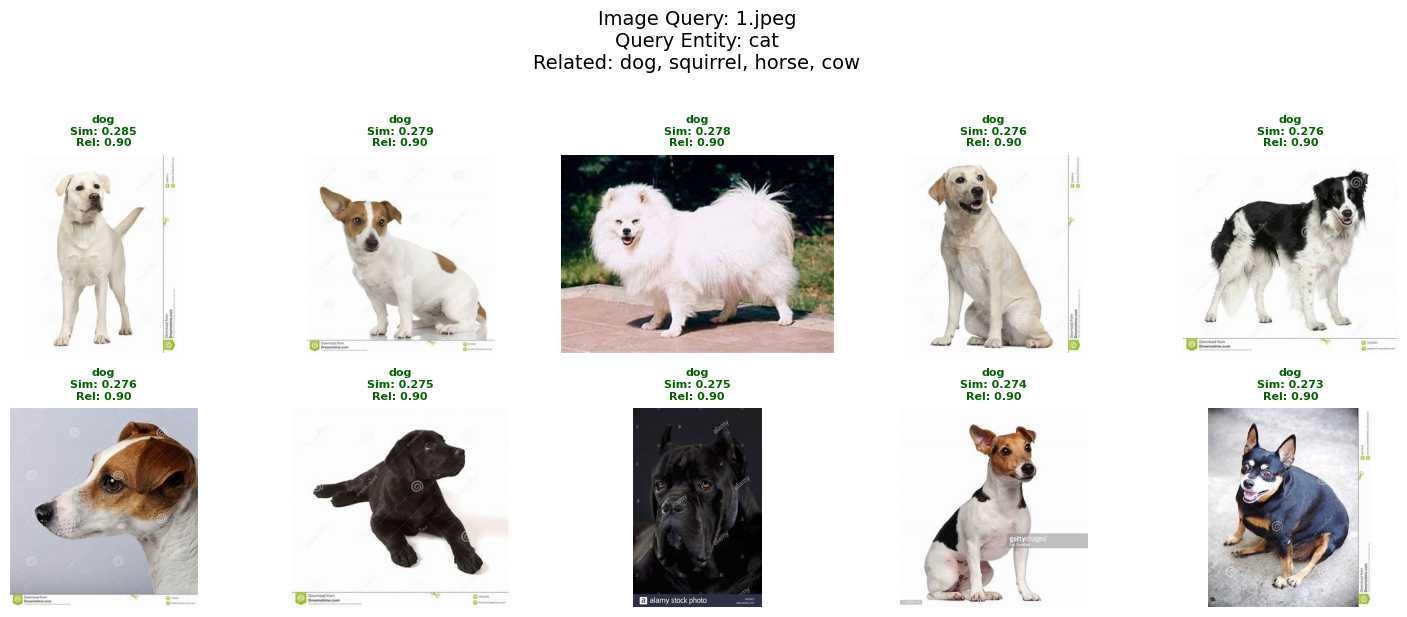

In [109]:
# Example with a cat image
query_image_path = r"e:\Projects\AI Based\RecTrio\datasets\animals\raw-img\cat\1.jpeg"

print(f"Querying with image: {query_image_path}\n")

# Get recommendations using knowledge graph
kg_results = kg_based_recommendation(
    query_input=query_image_path,
    input_type='image',
    top_k=10,
    use_semantic_expansion=True
)

print(f"\nTotal recommendations: {len(kg_results['recommendations'])}")
print("\nTop 5 recommendations:")
for i, result in enumerate(kg_results['recommendations'][:5], 1):
    entity = result.get('matched_label', 'unknown')
    sim = result['similarity']
    is_primary = result.get('is_primary', False)
    marker = "⭐" if is_primary else "  "
    print(f"{marker} {i}. {entity} - Similarity: {sim:.4f}")

# Display the results
display_kg_recommendations(kg_results, query_info=f"Image Query: {Path(query_image_path).name}")

Querying with text: 'a photo of an elephant'

Query entity: elephant
Related entities with strengths:
   - horse: 0.60
   - cow: 0.50
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations:
   1. horse - Similarity: 0.1975
   2. horse - Similarity: 0.1972
   3. horse - Similarity: 0.1959
   4. horse - Similarity: 0.1957
   5. horse - Similarity: 0.1957


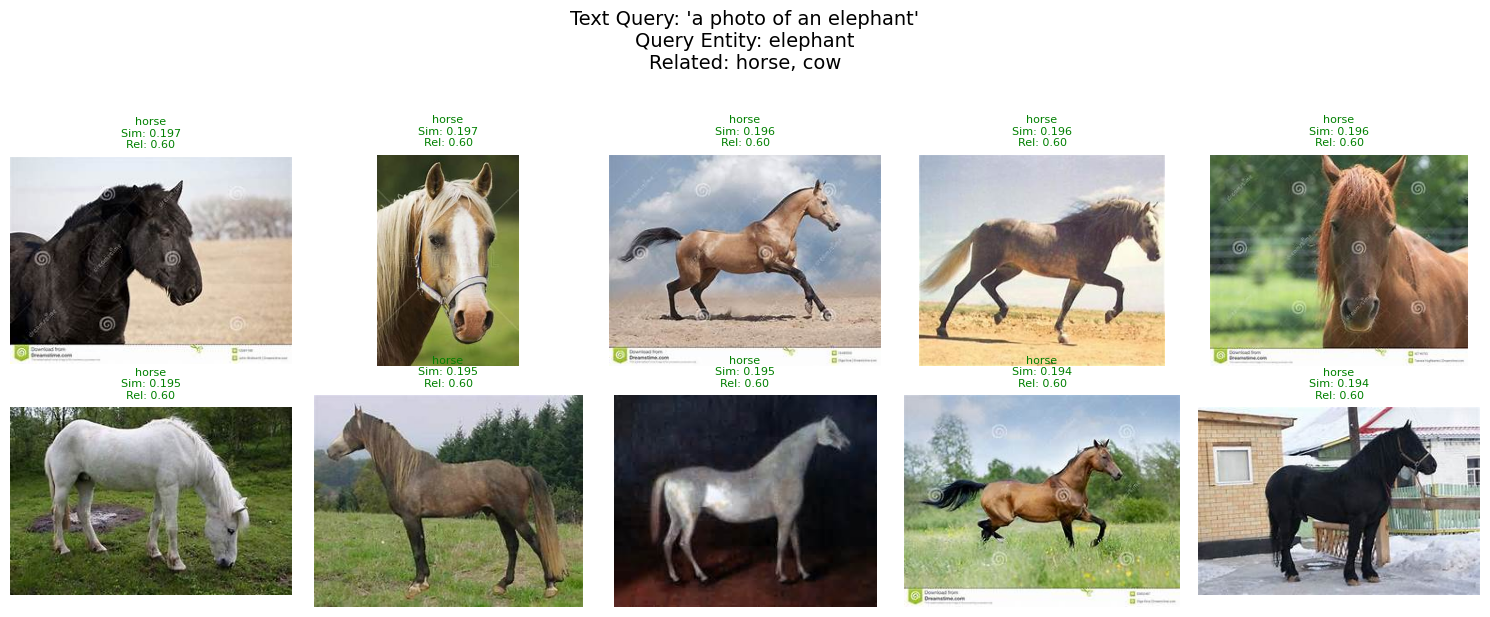

In [110]:
# Example with text query
query_text = "a photo of an elephant"

print(f"Querying with text: '{query_text}'\n")

# Get recommendations using knowledge graph
kg_results = kg_based_recommendation(
    query_input=query_text,
    input_type='text',
    top_k=10,
    use_semantic_expansion=True
)

print(f"\nTotal recommendations: {len(kg_results['recommendations'])}")
print("\nTop 5 recommendations:")
for i, result in enumerate(kg_results['recommendations'][:5], 1):
    entity = result.get('matched_label', 'unknown')
    sim = result['similarity']
    is_primary = result.get('is_primary', False)
    marker = "⭐" if is_primary else "  "
    print(f"{marker} {i}. {entity} - Similarity: {sim:.4f}")

# Display the results
display_kg_recommendations(kg_results, query_info=f"Text Query: '{query_text}'")

In [111]:
# Explore relationships in the knowledge graph
entity_to_explore = "dog"

print(f"Exploring entity: {entity_to_explore}\n")

if entity_to_explore in knowledge_graph['entities']:
    entity_info = knowledge_graph['entities'][entity_to_explore]
    
    print("Entity Information:")
    print(f"   Entity Name: {entity_to_explore}")
    
    print(f"\n🔗 Related Entities with Relationship Strengths:")
    related = get_related_entities(entity_to_explore, max_related=10)
    for rel_entity, strength in related:
        # Color-code by strength
        if strength >= 0.8:
            indicator = "Very Strong"
        elif strength >= 0.6:
            indicator = "Strong"
        elif strength >= 0.4:
            indicator = "Moderate"
        else:
            indicator = "Weak"
        print(f"   - {rel_entity}: {strength:.2f} ({indicator})")
    
    # Show total number of relationships
    print(f"\nTotal relationships: {len(related)}")
else:
    print(f"Entity '{entity_to_explore}' not found in knowledge graph")

Exploring entity: dog

Entity Information:
   Entity Name: dog

🔗 Related Entities with Relationship Strengths:
   - cat: 0.90 (Very Strong)
   - horse: 0.50 (Moderate)
   - squirrel: 0.50 (Moderate)
   - cow: 0.40 (Moderate)

Total relationships: 4


In [112]:
# Compare standard search vs knowledge graph-enhanced search
comparison_query = "butterfly"

print(f"Comparing search methods for: '{comparison_query}'\n")

# Standard text search
print("=" * 60)
print("STANDARD SEARCH (Text-only)")
print("=" * 60)
standard_embedding = get_text_embedding(f"a photo of a {comparison_query}")
standard_results = search_similar_images(standard_embedding, top_k=5)

print(f"\nTop 5 results:")
for i, result in enumerate(standard_results, 1):
    path_entity = find_entity_from_path(result['path'])
    print(f"{i}. {path_entity} - Similarity: {result['similarity']:.4f}")

# Knowledge graph-enhanced search
print("\n" + "=" * 60)
print("KNOWLEDGE GRAPH-ENHANCED SEARCH")
print("=" * 60)
kg_results = kg_based_recommendation(
    query_input=f"a photo of a {comparison_query}",
    input_type='text',
    top_k=10,
    use_semantic_expansion=True
)

print(f"\nTop 5 results:")
for i, result in enumerate(kg_results['recommendations'][:5], 1):
    entity = result.get('matched_label', 'unknown')
    sim = result['similarity']
    is_primary = result.get('is_primary', False)
    marker = "⭐" if is_primary else "🔗"
    print(f"{marker} {i}. {entity} - Similarity: {sim:.4f}")

print("\nKG-enhanced search provides:")
print("   ✓ Semantic expansion using related concepts")
print("   ✓ Context from entity relationships") 
print("   ✓ Diverse results across related categories")

Comparing search methods for: 'butterfly'

STANDARD SEARCH (Text-only)

Top 5 results:
1. butterfly - Similarity: 0.3262
2. butterfly - Similarity: 0.3243
3. butterfly - Similarity: 0.3214
4. butterfly - Similarity: 0.3205
5. butterfly - Similarity: 0.3204

KNOWLEDGE GRAPH-ENHANCED SEARCH
Query entity: butterfly
Related entities with strengths:
   - spider: 0.70
✓ Found 10 recommendations from related classes

Top 5 results:
🔗 1. spider - Similarity: 0.2313
🔗 2. spider - Similarity: 0.2285
🔗 3. spider - Similarity: 0.2283
🔗 4. spider - Similarity: 0.2282
🔗 5. spider - Similarity: 0.2273

KG-enhanced search provides:
   ✓ Semantic expansion using related concepts
   ✓ Context from entity relationships
   ✓ Diverse results across related categories


In [113]:
# Get recommendations for multiple related entities
entities_of_interest = ["cat", "dog", "horse"]

print(f"Getting recommendations for multiple entities: {entities_of_interest}\n")

all_entity_results = {}

for entity in entities_of_interest:
    print(f"\n{'='*60}")
    print(f"Processing: {entity}")
    print(f"{'='*60}")
    
    # Create text query for the entity
    text_query = f"a photo of a {entity}"
    
    # Get KG-based recommendations
    kg_results = kg_based_recommendation(
        query_input=text_query,
        input_type='text',
        top_k=5,
        use_semantic_expansion=False  # Disable expansion for focused results
    )
    
    all_entity_results[entity] = kg_results
    
    # Show summary
    print(f"Related entities: {kg_results['related_entities']}")
    print(f"Total recommendations: {len(kg_results['recommendations'])}")

# Show entity relationship matrix
print(f"\n\n{'='*60}")
print("ENTITY RELATIONSHIP MATRIX")
print(f"{'='*60}\n")

# Get all relationships
print("Entity relationships:")
for entity in entities_of_interest:
    if entity in knowledge_graph['entities']:
        related = knowledge_graph['entities'][entity]['related_entities']
        print(f"\n{entity.upper()}:")
        for rel_entity, strength in sorted(related.items(), key=lambda x: -x[1]):
            if rel_entity in entities_of_interest:
                print(f"  → {rel_entity}: {strength:.2f}")

print("\nHigher strength scores indicate stronger relationships in the knowledge graph")

Getting recommendations for multiple entities: ['cat', 'dog', 'horse']


Processing: cat
Query entity: cat
Related entities with strengths:
   - dog: 0.90
   - squirrel: 0.60
   - horse: 0.40
   - cow: 0.30
✓ Found 5 recommendations from related classes
Related entities: ['dog', 'squirrel', 'horse', 'cow']
Total recommendations: 5

Processing: dog
Query entity: dog
Related entities with strengths:
   - cat: 0.90
   - horse: 0.50
   - squirrel: 0.50
   - cow: 0.40
✓ Found 5 recommendations from related classes
Related entities: ['dog', 'squirrel', 'horse', 'cow']
Total recommendations: 5

Processing: dog
Query entity: dog
Related entities with strengths:
   - cat: 0.90
   - horse: 0.50
   - squirrel: 0.50
   - cow: 0.40
✓ Found 5 recommendations from related classes
Related entities: ['cat', 'horse', 'squirrel', 'cow']
Total recommendations: 5

Processing: horse
Query entity: horse
Related entities with strengths:
   - cow: 0.80
   - sheep: 0.60
   - elephant: 0.60
   - dog: 0.50
   - c